# Plotting Tools

In [1]:
import os
import csv
import pickle
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
import datetime


# Plot Armball tests 

In [2]:
log_dir = "./log" 
FIGSIZE = (15,9)
LW = 3

# Comparison

In [3]:
def plot_performance(means,stds,X=None,names=None,title="",ylabel="performance", minimum = -np.inf, maximum=np.inf,
                     log=False, double =False, xlabel="learning episodes"):
    if names is None:
        names = [str(j) for j in range(len(means))]
    compute_X = (X is None)
    if len(means)<5:
        ncol = [1,1,2,2,2][len(means)] 
    else:
        ncol = len(means)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    colors = ['crimson','royalblue','forestgreen','darkorange','orchid']
    handles = []
    for i in range(len(means)):
        if (double and i>=len(means)/2):
            linestyle = ":"
            color = colors[i%(len(means)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.array(means[i]), np.array(stds[i])
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
        ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
        plt.plot(X, mean_p_std, color=color, alpha=0.2)
        plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        if (X[1]-X[0])!=(X[-1]-X[-2]):
            plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2, loc="center left",ncol=ncol,bbox_to_anchor=(0., 1.07))
    plt.show()

# Pickle things

### test multi steps

In [ ]:
def compute_obs_noise_2move(episode, std):
    cube_moved = [0]
    for t in range(50):
        cube_has_moved = 1 if (np.linalg.norm(episode[t+1][3:6]-episode[t][3:6]) > 0.0001) else 0
        cube_moved.append(cube_has_moved)
    Obs = []
    for t in range(51):
        obs = np.concatenate((episode[t][:9],
                              episode[t][9:11]+np.random.normal(0,std,2),
                              episode[t][11:23],
                              episode[t][23:25]+np.random.normal(0,std,2)))
        #obs = episode[t][:25]+np.random.normal(0,std,25)
        Obs.append(np.concatenate((obs,[cube_moved[t]])))
    return Obs, np.sum(cube_moved)>0

def compute_obs_noise_move(episode, std):
    cube_moved = [0]
    for t in range(50):
        cube_has_moved = 1 if (np.linalg.norm(episode[t+1][3:6]-episode[t][3:6]) > 0.0001) else 0
        cube_moved.append(cube_has_moved)
    Obs = []
    for t in range(51):
        obs = episode[t]#+np.random.normal(0,std,8)
        Obs.append(obs)
    return Obs, np.sum(cube_moved)>0

In [ ]:
f = open("/home/tim/Documents/stage-m2/mypets/data/multiTask_80%_600.pk","br")
[data_obs1,data_acs1,success1] = pickle.load(f)
f.close()

f = open("/home/tim/Documents/stage-m2/mypets/data/multiTask_81%.pk","br")
[data_obs2,data_acs2,success2] = pickle.load(f)
f.close()

f = open("/home/tim/Documents/stage-m2/mypets/data/multiTask_80%_1200.pk","br")
[data_obs3,data_acs3,success3] = pickle.load(f)
f.close()

data_obs = np.concatenate((data_obs1,data_obs2,data_obs3), axis=1)
data_acs = np.concatenate((data_acs1,data_acs2,data_acs3), axis=1)
success = np.concatenate((success1,success2,success3), axis=1)

n_task = len(data_obs)
N_rollout = len(data_obs[0])

noise_std = 0.00

for run in range(1):
    for window_size in range(1,2):
        f = open("./data/transition_multi25_0noise_train.pk","bw")
        g = open("./data/transition_multi25_0noise_eval.pk","bw")
        
        train_Obs = []
        train_Acs = []

        eval_Obs = []
        eval_Acs = []

        for task in range(n_task):
            
            n_rollout = N_rollout
            eval_samples = random.sample(range(n_rollout),int(n_rollout/10))
            for rollout in range(n_rollout):
                noisy_obs = []
                obs = []
                
                std = 0. if (rollout in eval_samples) else noise_std
                noisy_obs, cube_has_moved = compute_obs_noise_move(data_obs[task,rollout], std )

                #if not cube_has_moved:
                for t in range(51):
                    obs.append(np.concatenate([noisy_obs[max(0,t-tau)] for tau in range(window_size)]))

                if rollout in eval_samples: 
                    eval_Obs.append(obs)
                    eval_Acs.append(data_acs[task,rollout])
                else:
                    train_Obs.append(obs)
                    train_Acs.append(data_acs[task,rollout])            

        pickle.dump([train_Obs,train_Acs], f) 
        pickle.dump([eval_Obs,eval_Acs], g) 
        f.close()
        g.close()

In [ ]:
np.shape(train_Obs)

In [ ]:
train_Obs[0][0]

### For solo episode

In [ ]:
f = open("/home/tim/Documents/stage-m2/mypets/data/multiTask_81%.pk","br")
[data_obs,data_acs,success] = pickle.load(f)
f.close()

noise_std = 0.00

f = open("./data/transition_multiTask_1_train.pk","bw")
g = open("./data/transition_multiTask_1_eval.pk","bw")

train_Obs = []
train_Acs = []

eval_Obs = []
eval_Acs = []

task = 9
rollout = 0

eval_obs,_ = compute_obs_noise_move(data_obs[task,rollout], 0. )
eval_Obs.append(eval_obs)
eval_Acs.append(data_acs[task,rollout])

for _ in range(100):
    obs,_ = compute_obs_noise_move(data_obs[task,rollout], noise_std )
    train_Obs.append(obs)
    train_Acs.append(data_acs[task,rollout])            

pickle.dump([train_Obs,train_Acs], f) 
pickle.dump([eval_Obs,eval_Acs], g) 
f.close()
g.close()

In [ ]:
np.shape(eval_Obs)

In [ ]:
minimum = np.min(data,axis=(0,1))
maximum = np.max(data,axis=(0,1))
print(maximum)
print(minimum)
np.min( [ maximum, np.max([minimum, np.random.random(26)], axis=0)], axis=0)

In [ ]:
moved_gripper/(12*40)

In [ ]:
moved_gripper/(12*40)

In [ ]:
[eval_Obs,eval_Acs] = data

j=22
x = []
y = []
for t in range(0,51):
    x.append(eval_Obs[j][t][1])
    y.append(eval_Obs[j][t][0])
x= np.array(x)
plt.plot(x)
plt.plot(y)
#plt.yscale('log')

## FetchPush trajectory prediction

In [ ]:
def plot_traj_pred(subdir, it,j, Tmax,eval_type, eval_data):
    eval_type = ['transition_error','traj_error'][eval_type]
    traj_error = loadmat(os.path.join(log_dir,subdir , "logs.mat"))[eval_type][eval_data]
    fig, ax = plt.subplots(figsize=FIGSIZE)
    colors = ['crimson','royalblue','forestgreen','darkorange','orchid']
    [traj_pred, true_traj, error] = traj_error[it]

    grip_pos = [[] for _ in range(5)]
    cube_pos = [[] for _ in range(5)]
    t_grip_pos = []
    t_cube_pos = []
    for t in range(Tmax):
        for i in range(5):
            grip_pos[i].append( traj_pred[t][j][i][:2])
            cube_pos[i].append( traj_pred[t][j][i][3:5])

        t_grip_pos.append(true_traj[j][t][:2])
        t_cube_pos.append(true_traj[j][t][3:5])
    
    t_grip_pos = np.array(t_grip_pos)
    t_cube_pos = np.array(t_cube_pos)
    grip_pos = np.array(grip_pos)
    cube_pos = np.array(cube_pos)
    
    plt.plot(t_grip_pos[:,0], t_grip_pos[:,1], c="black", lw=5,zorder=3)
    #plt.plot(t_cube_pos[:,0], t_cube_pos[:,1], c="black", lw=5, linestyle=":",zorder=3)
    
    handles = []
    handles.append( mlines.Line2D([], [], color = 'black', linestyle="-",linewidth=5, label= "True Gripper"))
    handles.append( mlines.Line2D([], [], color = 'black', linestyle=":",linewidth=5, label= "True Cube"))
    
    for i in range(5):
        plt.plot([grip_pos[i][t][0] for t in range(Tmax)], [grip_pos[i][t][1] for t in range(Tmax)],
                 alpha=0.5, c=colors[i], lw=LW)
        #plt.plot([cube_pos[i][t][0] for t in range(Tmax)], [cube_pos[i][t][1] for t in range(Tmax)],
        #         alpha=0.5, c=colors[i], lw=LW, linestyle=":")    

        handles.append( mlines.Line2D([], [], color = colors[i], linestyle="-",linewidth=3, label=str(i)))
    
    plt.legend(handles=handles, numpoints = 2, loc="center left",ncol=4,bbox_to_anchor=(0, 1.07))
    
    plt.xlabel("x")
    plt.ylabel("y")
    # plt.xlim(1,1.6)
    # plt.ylim(0.3,1.1)
    plt.title("Trajectory prediction")
    
def plot_traj_pred_perf_one_iteration(subdirs,names,it,eval_type, eval_data):
    eval_type = ['transition_error','traj_error'][eval_type]
    error_means = []
    error_stds = []
    for param_subdirs in subdirs:
        errors = []
        for subdir in param_subdirs:
            traj_error = loadmat(os.path.join(log_dir,subdir , "logs.mat"))[eval_type][eval_data]
            [_, _, error] = traj_error[it]
            error =  np.mean(error, axis=(0,2))
            errors.append(error)
        error_means.append(np.mean(errors, axis=0))
        error_stds.append(np.std(errors, axis=0))
    
    X = [i for i in range(51)]
    plot_performance(error_means,error_stds,X,names=names,title="Trajectory Prediction error",
                     xlabel="iteration in the episode",
                     ylabel="prediciton error", minimum = -np.inf, maximum=np.inf, log=True)
    
def plot_traj_pred_perf_all_training(subdirs,names,func):
    error_means = []
    error_stds = []
    for eval_data in [0,1]:
        for error_type in ['transition_error','traj_error']:
            for param_subdirs in subdirs:
                errors = []
                for subdir in param_subdirs:
                    traj_error = loadmat(os.path.join(log_dir,subdir , "logs.mat"))[error_type][eval_data]
                    error = []
                    for it in range(len(traj_error)-1):
                        [_, _, pred_error] = traj_error[it]
                        error.append(func(pred_error))
                    errors.append(error)
                error_means.append(np.mean(errors, axis=0))
                error_stds.append(np.std(errors, axis=0))

    names = [name+" trans" for name in names]+[name+" traj" for name in names]
    names = [name+" training" for name in names]+[name+" eval" for name in names]
    names = names*len(subdirs)
    plot_performance(error_means,error_stds,names=names,title="Trajectory Prediction error",
                     ylabel="prediciton error", minimum = -np.inf, maximum=np.inf, log=True, double=True)
    
def plot_traj_pred_training(subdir,func):
    error_means = []
    error_stds = []
    eval_data = 1
    error_type = 'traj_error'
    fig, ax = plt.subplots(figsize=FIGSIZE)
    traj_error = loadmat(os.path.join(log_dir,subdir , "logs.mat"))[error_type][eval_data]
    error = []
    for it in range(len(traj_error)):
        [_, _, pred_error] = traj_error[it]
        error.append(func(pred_error,axis=(0,1)))
 

    names = [str(i) for i in range(5)]
    for i in range(5):
        plt.plot([ error[it][i] for it in range(len(traj_error))], label=str(i),lw=LW)
    plt.legend()
    plt.yscale('log')
    
def print_train_test_grip_cube_error(subdirs,names):
    G_errors = []
    C_errors = []
    for data_eval in [0,1][1:2]:
        for error_type in ['transition_error','traj_error'][1:2]:
            c_error_means, c_error_stds, g_error_means, g_error_stds = [],[],[],[]
            for param_subdirs in subdirs:
                c_errors,g_errors = [],[]
                for subdir in param_subdirs:
                    traj_error = loadmat(os.path.join(log_dir,subdir , "logs.mat"))[error_type][data_eval]
                    it = -1
                    [pred_obs, obs, _] = traj_error[it]
                    c_error = np.mean([[[np.linalg.norm(obs[j][t][3:6]-pred_obs[t][j][i][3:6]) for i in range(5)] for t in range(51)] for j in range(len(obs))])
                    g_error = np.mean([[[np.linalg.norm(obs[j][t][:3]-pred_obs[t][j][i][:3]) for i in range(5)] for t in range(51)] for j in range(len(obs))])
                    c_errors.append(c_error)
                    g_errors.append(g_error)
                c_error_means.append(c_errors)
                g_error_means.append(g_errors)
            G_errors.append(g_error_means)
            C_errors.append(c_error_means)

    fig,axarr = plt.subplots(2,1, sharex=True,figsize=FIGSIZE)
    axarr[0].boxplot(G_errors[-1])
    axarr[0].set_title("Gripper error")
    axarr[1].boxplot(C_errors[-1])
    axarr[1].set_title("Cube error")
    axarr[1].set_ylabel("Error")
    plt.xticks([i for i in range(1,1+len(names))],names)
  


In [ ]:
test = "2019-04-04--13:22:33"
with_noise = "2019-04-04--13:31:30"
with_lessnoise ="2019-04-04--13:35:55"
       
test_withconstant = "2019-04-04--15:48:17"
test_8d = "2019-04-04--16:16:29"
bounded_8d = "2019-04-04--16:44:48"
    
multi_nonoise_200 = "2019-04-04--13:44:45"
multi_nonoise_500 = "2019-04-04--13:54:26"
multi_nonoise_1000 = "2019-04-04--15:04:39"

multi_nonoise_bounded_1000 ="2019-04-04--17:30:03"
multi_nonoise_bounded_1000_2 ="2019-04-04--17:51:42"

multi_allnoise_1000 = "2019-04-05--14:27:24"
multi_4noise_1000 = "2019-04-05--14:53:09"
    
test_6d = "2019-04-05--13:36:13"    
test_8d_nonoise = "2019-04-05--13:42:23"
test_8d_2noise = "2019-04-05--13:51:41"

test = "2019-04-05--14:38:45"

test_2d = "2019-04-05--17:05:45"
test_2d_2 = "2019-04-05--17:13:03"

pets1 = test_8d_nonoise
pets2 = test_8d_nonoise_2
pets3 = "/home/tim/Documents/stage-m2/mypets/log/2019-04-08--10:49:46"
pets4 = "/home/tim/Documents/stage-m2/mypets/log/2019-04-08--10:59:48"  
pets5 = "/home/tim/Documents/stage-m2/mypets/log/2019-04-08--11:05:28"

swish = [pets1,pets2,pets3,pets4,pets5]

relu_1 = "2019-04-08--11:46:37"
relu_2 = "2019-04-08--13:31:01"
relu_3 = "2019-04-08--13:38:54"
relu_4 = "2019-04-08--13:44:20"

relu = [relu_1,relu_2,relu_3,relu_4]

multi_26d_relu_1 = "2019-04-08--14:04:36"

multi_25d_relu_1 = "2019-04-08--14:23:15"
multi_25d_relu_2 = "2019-04-08--14:47:20"
multi_25d_relu_3 = "2019-04-08--15:09:48"
    
multi_25d_swish_1 = "2019-04-08--15:22:08"
multi_25d_swish_2 = "2019-04-08--15:34:47"

multi_25d_relu_DE_1_switch_evaltrain = "2019-04-09--10:31:50"

multi_25d_relu_DE_1 = "2019-04-09--17:24:40"
multi_25d_relu_DE_0decay = "2019-04-09--17:36:35"

multi_1_DE_relu = "2019-04-09--11:19:38"
multi_1_PE_relu = "2019-04-09--11:34:59"
multi_1_DE_swish = "2019-04-09--14:45:59"
multi_1_PE_swish = "2019-04-09--14:51:27"

multi_8d_DE_swish = "2019-04-09--15:48:55"

subdirs = [[multi_25d_relu_DE_1,multi_25d_relu_DE_2, multi_25d_relu_DE_2],
          [multi_25d_relu_1,multi_25d_relu_2,multi_25d_relu_3]]

subdirs =  [[multi_25d_relu_DE_1 ], [multi_25d_relu_DE_0decay]]

names = ["DE","PE"]

In [ ]:
subdir = multi_nonoise_bounded_1000
f = open("./log/"+subdir+"/myconfig.pk","br")
data = pickle.load(f)
f.close()
data

In [ ]:
print_train_test_grip_cube_error(subdirs, names)

In [ ]:
names = ["one"]
plot_traj_pred_perf_one_iteration(subdirs,names,10,eval_type=1,eval_data=1)

In [ ]:
plot_traj_pred_perf_all_training(subdirs,names,np.median)

In [ ]:
plot_traj_pred_training(subdirs[0][0],np.max)

In [ ]:
plot_traj_pred(subdirs[1][0], it=10,j=0,Tmax=3,eval_data=0,eval_type=0)

In [ ]:
def plot_local_error(subdir,it,Tmax, Pmax):
    j = 0
    traj_error = loadmat(os.path.join(log_dir,subdir, "logs.mat"))['traj_error'][1]
    [pred_obs, obs, _] = traj_error[it]
    error = np.zeros((Tmax+1,Pmax))
    for t in range(1,Tmax+1):
        for p in range(Pmax):
            models_error = []
            for i in range(5):
                models_error.append(np.mean(np.abs(pred_obs[t,:,i,p]-obs[:,t,p])))
            error[t][p] = np.mean(models_error)
            
    fig, ax = plt.subplots(figsize=FIGSIZE)
    for p in range(Pmax):
        plt.plot(error[:,p],label=str(p),lw=LW)
    plt.legend()

def plot_local_value(subdir,it,Tmax, Pmax,j):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    traj_error = loadmat(os.path.join(log_dir,subdir, "logs.mat"))['traj_error'][1]
    [pred_obs, obs, _] = traj_error[it]

    error = np.zeros((Tmax+1,Pmax))
    for t in range(Tmax+1):
        for p in range(Pmax):
            models_error = []
            for i in [4]:
                #models_error.append((pred_obs[t,j,i,p]-pred_obs[0,j,i,p]))
                models_error.append((pred_obs[t,j,i,p]))
            error[t][p] = np.mean(models_error)

    colors = ["red","maroon","coral","green","seagreen","darkgreen","indigo","royalblue","steelblue"]
    i = 0
    for p in range(Pmax):
    #for p in [25] :
        plt.plot(error[:,p],label=str(p),ls=":",lw=LW,c=colors[i%8])
        #plt.plot(obs[j,:Tmax+1,p]-obs[j,0,p],c=colors[i%7],lw=LW,alpha=1)
        plt.plot(obs[j,:Tmax+1,p],c=colors[i%8],lw=LW,alpha=0.5)
        i+=1

    plt.legend()
    #plt.yscale('log')

In [ ]:
error = plot_local_value(subdirs[0][0],10,Tmax=5,Pmax=2,j=0)

In [ ]:
subdir = test_8d_nonoise_2
traj_error = loadmat(os.path.join(log_dir,subdir, "logs.mat"))['traj_error'][1]
[pred_obs, obs, er] = traj_error[10]

In [ ]:
np.shape(er)

# Compare Nsamples error

In [ ]:
import list_logfile 

subdirs = list_logfile.subdirs_full_trans_noise 
Nsamples = np.array([1,2,5,10,20,50,100,200,500,900])
names = np.ndarray.astype(Nsamples,str)

subdirs = subdirs[:9]
Nsamples = Nsamples[:9]

In [ ]:
Nsamples = np.array([1,2,5,10,20,50,100,200,500,900])
names = np.ndarray.astype(Nsamples,str)

subdirs=subdirs2

In [ ]:
for i in range(len(subdirs)):
    for run in range(len(subdirs[i])):
        with open(os.path.join(log_dir,subdirs[i][run], "myconfig.pk"), "br") as f:
            cfg = pickle.load(f)
            print(Nsamples[i],run,cfg['Nsamples']==Nsamples[i] and cfg['run']==run)

In [ ]:
def plot_train_test_error(Subdirs,names,median=False):
    means = []
    stds = []
    
    for subdirs in Subdirs:
        for data_eval in [0,1]:
            for error_type in ['transition_error','traj_error'][:2]:
                error_means = []
                error_stds = []
                for param_subdirs in subdirs:
                    errors = []
                    for subdir in param_subdirs:
                        traj_error = loadmat(os.path.join(log_dir,subdir , "logs.mat"))[error_type][data_eval]
                        it = -1
                        [_, _, pred_error] = traj_error[it]
                        error = np.mean(pred_error)
                        errors.append(error)
                    if median:
                        error_means.append(np.median(errors))
                        error_stds.append(0)
                    else:
                        error_means.append(np.mean(errors))
                        error_stds.append(np.std(errors))
                means.append(error_means)
                stds.append(error_stds)
    
    X = Nsamples
    names = ["transition training","trajectory training","transition test","trajectory test" ]*2
    #names = ["transition training","transition test"]
    plot_performance(means,stds,X=X,names=names,title="Transition/Trajectory Prediction Error",
                     ylabel="prediciton error",xlabel="Nsamples",
                     minimum = -np.inf, maximum=np.inf, log=True, double=True)

def plot_train_test_grip_cube_error(subdirs,names):
    means = []
    stds = []
    for data_eval in [0,1][:2]:
        for error_type in ['transition_error','traj_error'][:2]:
            c_error_means, c_error_stds, g_error_means, g_error_stds = [],[],[],[]
            for param_subdirs in subdirs:
                c_errors,g_errors = [],[]
                for subdir in param_subdirs:
                    traj_error = loadmat(os.path.join(log_dir,subdir , "logs.mat"))[error_type][data_eval]
                    it = -1
                    [pred_obs, obs, _] = traj_error[it]
                    c_error = np.mean([[[np.linalg.norm(obs[j][t][3:6]-pred_obs[t][j][i][3:6]) for i in range(5)] for t in range(51)] for j in range(len(obs))])
                    g_error = np.mean([[[np.linalg.norm(obs[j][t][:3]-pred_obs[t][j][i][:3]) for i in range(5)] for t in range(51)] for j in range(len(obs))])
                    c_errors.append(c_error)
                    g_errors.append(g_error)
                c_error_means.append(np.mean(c_errors))
                c_error_stds.append(np.std(c_errors))
                g_error_means.append(np.mean(g_errors))
                g_error_stds.append(np.std(g_errors))                
            means.append(g_error_means)
            stds.append(g_error_stds) 
            means.append(c_error_means)
            stds.append(c_error_stds)

    X = Nsamples
    names = []
    for data_eval in ['traning ','test ']:
        for type_eval in ['transition ', 'trajectory '][:2]:
            for obj in ['gripper','cube']:
                 names.append(data_eval+type_eval+obj)
 
    plot_performance(means,stds,X=X,names=names,title="Transition/Trajectory Prediction Error",
                     ylabel="prediciton error",xlabel="Nsamples",
                     minimum = -np.inf, maximum=np.inf, log=True, double=True)

In [ ]:
plot_train_test_grip_cube_error(subdirs,names)

In [ ]:
plot_train_test_error([subdirs1,subdirs2],names,False)

In [ ]:
def plot_traj_pred(subdir, it,j, Tmax,eval_type, eval_data):
    eval_type = ['transition_error','traj_errors'][eval_type]
    traj_error = loadmat(os.path.join(log_dir,subdir , "logs.mat"))[eval_type][eval_data]
   
    
    fig, ax = plt.subplots(figsize=FIGSIZE)
    colors = ['crimson','royalblue','forestgreen','darkorange','orchid']
    [traj_pred, true_traj, error] = traj_error[it]

    grip_pos = [[] for _ in range(5)]
    cube_pos = [[] for _ in range(5)]
    t_grip_pos = []
    t_cube_pos = []
    for t in range(Tmax):
        for i in range(5):
            grip_pos[i].append( traj_pred[t][j][i][:2])
            cube_pos[i].append( traj_pred[t][j][i][3:5])

        t_grip_pos.append(true_traj[j][t][:2])
        t_cube_pos.append(true_traj[j][t][3:5])
    
    t_grip_pos = np.array(t_grip_pos)
    t_cube_pos = np.array(t_cube_pos)
    grip_pos = np.array(grip_pos)
    cube_pos = np.array(cube_pos)
    
    plt.plot(t_grip_pos[:,0], t_grip_pos[:,1], c="black", lw=5,zorder=3)
    plt.plot(t_cube_pos[:,0], t_cube_pos[:,1], c="black", lw=5, linestyle=":",zorder=3)
    
    handles = []
    handles.append( mlines.Line2D([], [], color = 'black', linestyle="-",linewidth=5, label= "True Gripper"))
    handles.append( mlines.Line2D([], [], color = 'black', linestyle=":",linewidth=5, label= "True Cube"))
    
    for i in range(5):
        plt.plot([grip_pos[i][t][0] for t in range(Tmax)], [grip_pos[i][t][1] for t in range(Tmax)],
                 alpha=0.5, c=colors[i], lw=LW)
        plt.plot([cube_pos[i][t][0] for t in range(Tmax)], [cube_pos[i][t][1] for t in range(Tmax)],
                 alpha=0.5, c=colors[i], lw=LW, linestyle=":")    

        handles.append( mlines.Line2D([], [], color = colors[i], linestyle="-",linewidth=3, label=str(i)))
    
    plt.legend(handles=handles, numpoints = 2, loc="center left",ncol=4,bbox_to_anchor=(0, 1.07))
    
    plt.xlabel("x")
    plt.ylabel("y")
    # plt.xlim(1,1.6)
    # plt.ylim(0.3,1.1)
    plt.title("Trajectory prediction")

In [ ]:
plot_traj_pred("2019-03-28--11:40:11", it=10,j=0, Tmax=50,eval_type=1, eval_data=2)

# Test easy env

In [ ]:
f = open("./data/transition_hardd1_train.pk","bw")
g = open("./data/transition_hardd1_eval.pk","bw")

train_Obs = []
train_Acs = []

eval_Obs = []
eval_Acs = []

n_rollout = 100

eval_samples = random.sample(range(n_rollout),int(n_rollout/10))

for rollout in range(n_rollout):
    acs = []
    false_acs = []
    obs = [np.zeros(1)]

    for t in range(50):
        acs.append(2*np.random.random(1)-1)
        false_acs.append(2*np.random.random(1)-1)
        obs1 = np.min( [np.array([0.5]),obs[-1][:4]+acs[-1]],axis=0)
        #obs.append( np.concatenate([obs1,np.zeros(4)]))
        obs.append( obs1)

    if rollout in eval_samples: 
        eval_Obs.append(obs)
        eval_Acs.append(false_acs)
    else:
        train_Obs.append(obs)
        train_Acs.append(false_acs)            

pickle.dump([train_Obs,train_Acs], f) 
pickle.dump([eval_Obs,eval_Acs], g) 
f.close()
g.close()

In [ ]:
np.shape(train_Obs)

In [ ]:
np.shape(eval_Obs)

In [ ]:
test_100 = "2019-04-05--10:44:05"
test_100_20n = "2019-04-05--10:58:58"
test_100_2n = "2019-04-05--11:05:02"

test_100_2n_2 = "2019-04-05--11:12:52"
test_1n = "2019-04-05--13:33:42"

test_bound = "2019-04-05--15:47:38"
test = "2019-04-09--15:16:17"
subdirs = [[test]]

test_8d = "2019-04-08--17:37:42"

names = ['200','20','2']


In [ ]:
plot_traj_pred_perf_all_training(subdirs,names,np.max)

In [ ]:
def plot_traj(subdir,names,it,j,Tmax,eval_type):
    eval_type = ['transition_error','traj_error'][eval_type]
    fig, ax = plt.subplots(figsize=FIGSIZE)

    data = loadmat(os.path.join(log_dir,subdir , "logs.mat"))[eval_type]
    [data_train,data_eval] = data
    [pred,obs,error] = data_eval[it]
    print(np.shape(pred))
    colors = ["red","darkgreen","indigo","royalblue","steelblue"]
    
    for p in range(1):
        for i in range(5):
            plt.plot(pred[:Tmax,j,i,p],lw=LW,ls=":",label=str(p))

    plt.plot(obs[j,:Tmax],lw=LW,alpha=0.3)
    plt.legend()

In [ ]:
names= ['bounded by 1','constant 0']
plot_traj(subdirs[0][0],names,it=10,j=0,Tmax=50,eval_type=0)

In [ ]:
def plot_traj(subdirs,Tmax,eval_type):
    eval_type = ['transition_error','traj_errors'][eval_type]
    fig, ax = plt.subplots(figsize=FIGSIZE)
    similarity = []
    for it in range(11):
        preds = []
        for subdir in subdirs:
            data = loadmat(os.path.join(log_dir,subdir[0] , "logs.mat"))[eval_type]
            [data_train,data_eval] = data
            [pred,obs,error] = data_train[it]
            preds.append(pred[:Tmax,j,3])
        similarity.append(np.linalg.norm(preds[0]-preds[1]))
    plt.plot(similarity,lw=LW)

In [ ]:
plot_traj(subdirs,1Tmax=40,eval_type=0)

# Sklearn

In [ ]:
from sklearn import neural_network

## learning

In [ ]:
def learn():
    MLP = neural_network.MLPRegressor(hidden_layer_sizes=(400,400,400),
                                           activation='relu',
                                           solver='adam',
                                           learning_rate='adaptative',
                                           max_iter=50,
                                           learning_rate_init=0.001,
                                           alpha=0.0005,
                                           verbose=True)
    f = open("./data/transition_multi25_0noise_train.pk" , 'rb')
    [true_traj,Acs] = pickle.load(f)
    f.close()
    Inputs = []
    Targets = []
    for j in range(len(true_traj)):
        for t in range(50):
            inputs = np.concatenate((true_traj[j][t],Acs[j][t]))
            targets = true_traj[j][t+1]- true_traj[j][t]
            Inputs.append(inputs)
            Targets.append(targets)
    cfg = MLP.fit(Inputs,Targets)
    return MLP

## eval

In [ ]:
def evaluation(MLP):
    f = open("./data/transition_multi25_0noise_eval.pk" , 'rb')
    [true_traj,Acs] = pickle.load(f)
    f.close()

    pred = []
    error_traj = []
    for j in range(len(true_traj)):
        obs = [true_traj[j][0]]
        for t in range(50):
            inputs = np.array([np.concatenate((obs[-1],Acs[j][t]))])
            obs.append(MLP.predict(inputs)[0]+obs[-1])
        pred.append(obs)
        error_traj.append( np.linalg.norm(obs-np.array(true_traj[j])))
    true_traj = np.array(true_traj)
    pred_traj = np.array(pred)
    
    pred = []
    error_trans = []
    for j in range(len(true_traj)):
        obs = [true_traj[j][0]]
        for t in range(50):
            inputs = np.array([np.concatenate((true_traj[j][t],Acs[j][t]))])
            obs.append(MLP.predict(inputs)[0]+true_traj[j][t])
        pred.append(obs)
        error_trans.append( np.linalg.norm(obs-np.array(true_traj[j])))
    pred_trans = np.array(pred)
    
    timestamp = datetime.datetime.now()
    filename = "/home/tim/Documents/stage-m2/mypets/log/sklearn/"+str(timestamp)+".pk"
    f = open(filename,'bw')
    pickle.dump((pred_traj,pred_trans,true_traj,error_traj,error_trans,str(cfg)),f)
    f.close()

In [ ]:
for _ in range(1):
    MLP = learn()
    evaluation(MLP)

In [1]:
pets1 = test_8d_nonoise
pets2 = test_8d_nonoise_2
pets3 = "/home/tim/Documents/stage-m2/mypets/log/2019-04-08--10:49:46"
pets4 = "/home/tim/Documents/stage-m2/mypets/log/2019-04-08--10:59:48"  
pets5 = "/home/tim/Documents/stage-m2/mypets/log/2019-04-08--11:05:28"

sk1 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 10:33:33.146522.pk"
sk2 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 10:44:50.148105.pk"
sk3 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 10:39:26.084127.pk"
sk4 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 10:46:49.046232.pk"
sk5 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 10:47:47.898961.pk"
sk6 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:01:18.741830.pk"
sk7 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:01:52.131434.pk"
sk8 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:02:47.825512.pk"
sk9 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:03:29.446214.pk"
sk10 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:03:50.102582.pk"
sk11 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:13:53.825773.pk"
sk12 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:14:33.508463.pk"
sk13 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:15:15.521200.pk"
sk14 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:15:43.231902.pk"
sk15 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:15:57.914413.pk"
sk16 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:16:20.328159.pk"
sk17 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:16:51.342673.pk"
sk18 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:17:05.934099.pk"
sk19 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:17:22.129538.pk"
sk20 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:17:36.260764.pk"


sk=[sk1,sk2,sk3,sk4,sk5,sk6,sk7,sk8,sk9,sk10,sk11,sk12,sk13,sk14,sk15,sk16,sk17,sk18,sk19,sk20]

new_sk1 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:31:05.573569.pk"
new_sk2 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:33:28.862192.pk"
new_sk3 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:37:50.459211.pk"
new_sk4 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:38:55.066315.pk"
new_sk5 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 11:39:38.997026.pk"
new_sk = [new_sk1, new_sk2, new_sk3, new_sk4, new_sk5]

pets = [pets1,pets2,pets3,pets4,pets5]


sk_25d_relu_1 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 14:37:46.639083.pk"
sk_25d_relu_2 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 14:44:07.869157.pk"
sk_25d_relu_3 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 14:46:22.059378.pk"
sk_25d_relu_4 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 14:56:40.606593.pk"
sk_25d_relu_5 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 14:56:09.448843.pk"
sk_25d_relu_6 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-08 14:55:44.275356.pk"

sk_25d_withobs = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-09 13:29:34.461006.pk"

sk = [sk_25d_relu_1,sk_25d_relu_2,sk_25d_relu_3,sk_25d_relu_4,sk_25d_relu_5,sk_25d_relu_6]

pets_25d_relu_1 = multi_25d_relu_1
pets_25d_relu_2 = multi_25d_relu_2
pets_25d_relu_3 = multi_25d_relu_3
        
pets = [pets_25d_relu_1, pets_25d_relu_2, pets_25d_relu_3] 

pets_DE = [multi_25d_relu_DE_1]

sk_200 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-09 13:53:00.691342.pk"
sk_400 = "/home/tim/Documents/stage-m2/mypets/log/sklearn/2019-04-10 11:40:34.066065.pk"

sk = [sk_200,sk_400]
pets_swish = [multi_25d_swish_1,multi_25d_swish_2 ]

NameError: name 'test_8d_nonoise' is not defined

In [ ]:
def comparison_one_to_one(sklearn_files,pets_file):
    # PETS
    if len(pets_file)>0:
        traj_error = loadmat(os.path.join(log_dir,pets_file, "logs.mat"))['traj_error'][1]
        [pred_obs, obs, er] = traj_error[-1]
        pets_error = [[] for _ in range(5)]
        for j in range(len(obs)):
            for i in range(5):
                pets_error[i].append( np.linalg.norm(obs[j]-np.array(pred_obs[:,j,i])))
        
        for i in range(5):
            plt.plot(pets_error[i],lw=LW,label="pets "+str(i))
        
    # sklearn
    traj,trans =[], []
    for sklearn_file in sklearn_files:
        f = open(sklearn_file,'br')
        (pred_traj,pred_trans,true_traj,error_traj,error_trans,cfg) = pickle.load(f)
        f.close()
        traj.append(error_traj)
        trans.append(error_trans)
    
    fig, ax = plt.subplots(figsize=FIGSIZE)
    

    for i in range(len(traj)):
        plt.plot(traj[i], lw=LW,ls=":",label="sklearn",zorder=3)
        plt.plot(trans[i], lw=LW,ls="-",label="sklearn",zorder=3)


    plt.legend()
    plt.yscale('log')

In [ ]:
comparison_one_to_one(sk,[] )

In [ ]:
def comparison_average(sklearn_files,pets_files,func):
    # PETS
    pets_error = []
    for pets_file in pets_files:
        traj_error = loadmat(os.path.join(log_dir,pets_file, "logs.mat"))['traj_error'][1]
        [pred_obs, obs, er] = traj_error[-1]
        for i in range(5):
            pets_error.append([])
            for j in range(len(obs)):
                pets_error[-1].append( np.linalg.norm(obs[j]-np.array(pred_obs[:,j,i])))
    
    pets_mean = func(pets_error,axis=(0))
    pets_stds = np.std(pets_error,axis=(0))
    # sklearn
    sklearn_errors=[]
    for sklearn_file in sklearn_files:
        f = open(sklearn_file,'br')
        (pred_traj,pred_trans,true_traj,error_traj,error_trans,cfg) = pickle.load(f)
        f.close()
        sklearn_errors.append(error_traj)
    
    sklearn_mean = func(sklearn_errors,axis=0)
    sklearn_stds = np.std(sklearn_errors,axis=0)
    names=['pets',"sklearn"]
    plot_performance([pets_mean,sklearn_mean],[pets_stds,sklearn_stds],log=True,names=names)

In [ ]:
comparison_average(sk,pets_DE,np.mean)

In [ ]:
def plot_episodes_errors(subdirs,names,func):
    means = []
    stds = []
    for param in subdirs:
        pets_error = []
        for subdir in param:
            traj_error = loadmat(os.path.join(log_dir,subdir, "logs.mat"))['traj_error'][1]
            [pred_obs, obs, er] = traj_error[-1]
            for i in range(5):
                pets_error.append([])
                for j in range(len(obs)):
                    pets_error[-1].append( np.linalg.norm(obs[j]-np.array(pred_obs[:,j,i])))

        means.append(func(pets_error,axis=(0)))
        stds.append(np.std(pets_error,axis=(0)))
        
    plot_performance(means,stds,log=True,names=names,ylabel="trajectory prediction error",xlabel="evaluation episode")

In [ ]:
subdirs = [pets,pets_swish,pets_DE]
names = ['ReLU','swish',"DE"]
plot_episodes_errors(subdirs,names,np.median)

# My tensorflow

In [28]:
def plot_episodes_errors(subdirs,names,func,data):
    data = ['training.pk','eval.pk'][data]
    traj_means, trans_means = [], []
    traj_stds, trans_stds = [], []
    for param in subdirs:
        traj_errors = []
        trans_errors = []
        for subdir in param:
            f = open(subdir+data,'br')
            (pred_traj,pred_trans,true_traj,_,_) = pickle.load(f)
            true_traj = true_traj[:,:,:25]
            f.close()

            traj_errors.append(func(np.linalg.norm( pred_traj-true_traj, axis=(2)), axis=1))
            trans_errors.append(func(np.linalg.norm( pred_trans-true_traj, axis=(2)), axis=1))
        traj_means.append(np.mean(traj_errors, axis=0))
        trans_means.append(np.mean(trans_errors, axis=0))
        trans_stds.append(np.std(trans_errors, axis=0))
        traj_stds.append(np.std(traj_errors, axis=0))

    means = traj_means+trans_means
    stds = traj_stds +trans_stds
    
    names = [name+' traj' for name in names]+ [name+' trans' for name in names]
    plot_performance(means,stds,log=True,names=names,ylabel="trajectory prediction error",xlabel="evaluation episode")
    
    fig,axarr = plt.subplots(2,1, sharex=True,figsize=FIGSIZE)

    plt.subplot(211)
    plt.title("trajectory error")
    plt.boxplot(traj_means)
    plt.yscale('log')
    plt.xticks([i for i in range(1,1+len(names)//2)],names[:len(names)//2])
    
    plt.subplot(212)
    plt.boxplot(trans_means)
    plt.title("transition error")
    plt.ylabel("Error")
    plt.yscale('log')
    
    plt.xticks([i for i in range(1,1+len(names)//2)],names[:len(names)//2])

In [136]:
def plot_traj(subdir,j,Tmax,pred_type, eval_type):
    if eval_type:
        file = "eval.pk"
    else:
        file = "training.pk"
    f = open(subdir+file,'br')
    (pred_traj,pred_trans,true_traj,error_traj,error_trans) = pickle.load(f)
    if pred_type:
        pred = pred_traj
        print(error_traj[j])
    else:
        pred = pred_trans
        print(error_trans[j])
    f.close()
    fig, ax = plt.subplots(figsize=FIGSIZE)

    plt.plot(pred[j,:Tmax,0], pred[j,:Tmax,1],lw=LW,ls=":",zorder=3,c="darkgreen",label="gripper")
    #plt.plot(true_traj[j,:Tmax,0], true_traj[j,:Tmax,1],lw=LW,ls="-",c="darkgreen")
    
    plt.plot(pred[j,:Tmax,3], pred[j,:Tmax,4],lw=LW,ls=":",zorder=3,c="red",label="cube")
    #plt.plot(true_traj[j,:Tmax,3], true_traj[j,:Tmax,4],lw=LW,ls="-",c="red")    
    
    plt.legend()

In [137]:
random = "/home/tim/Documents/stage-m2/tf_test/log/2019-04-17 14:11:21.992403/"
no_norm = "/home/tim/Documents/stage-m2/tf_test/log/2019-04-17 14:35:06.965082/"

test_1 = "/home/tim/Documents/stage-m2/tf_test/log/2019-04-17 15:19:28.261623/"

test = "/home/tim/Documents/stage-m2/tf_test/log/2019-04-17 16:05:50.008004/"

subdirs = [[test]]
names = ["random"]

360595223696.64014


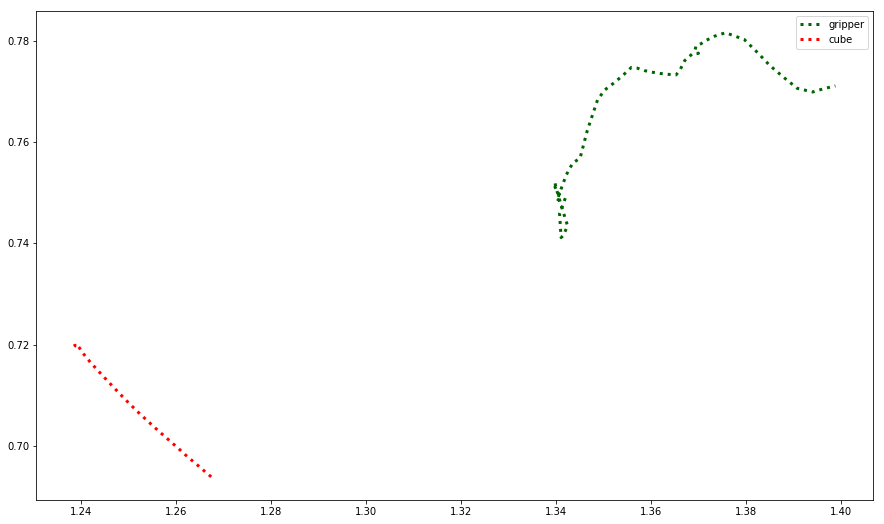

In [138]:
plot_traj(subdirs[0][0],j=0,Tmax=50,pred_type=1, eval_type=1)

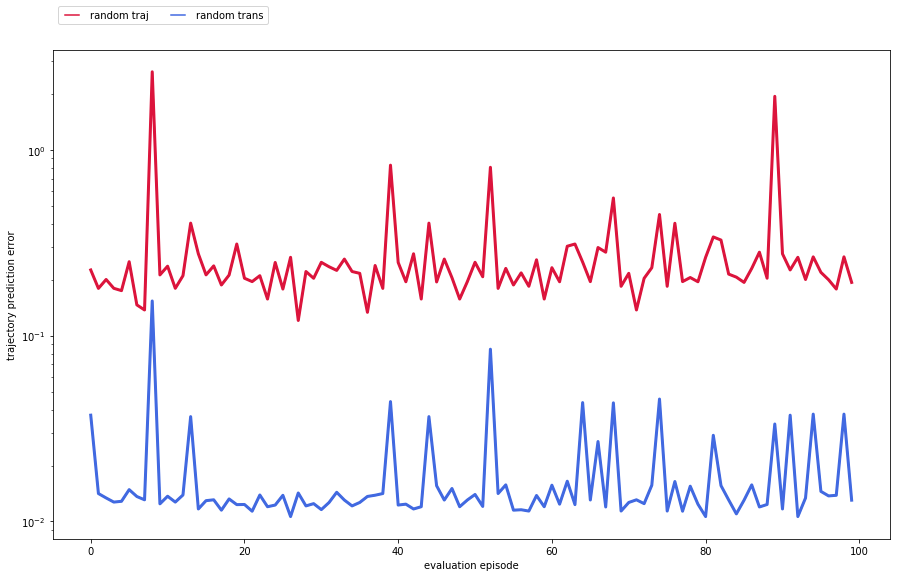

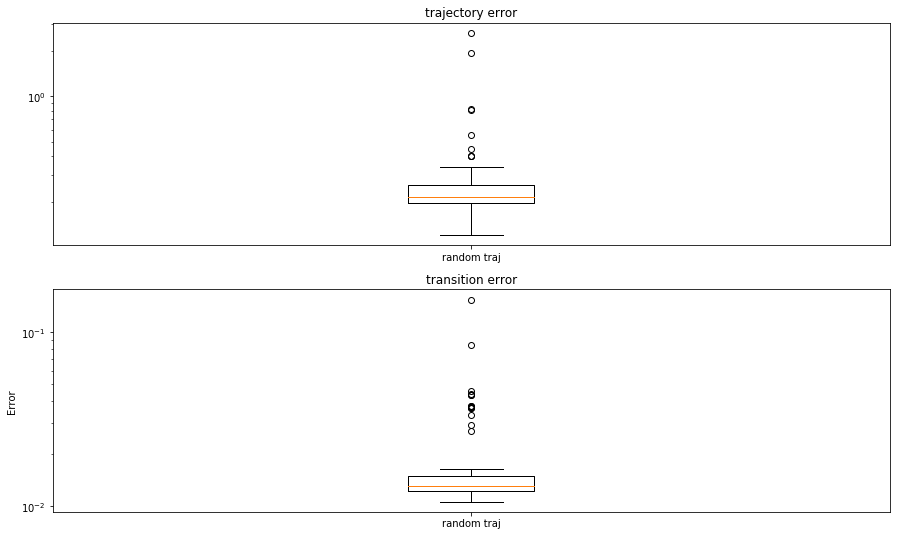

In [102]:
plot_episodes_errors(subdirs,names,np.mean,0)

Text(0.5, 1.0, 'Training trajectories')

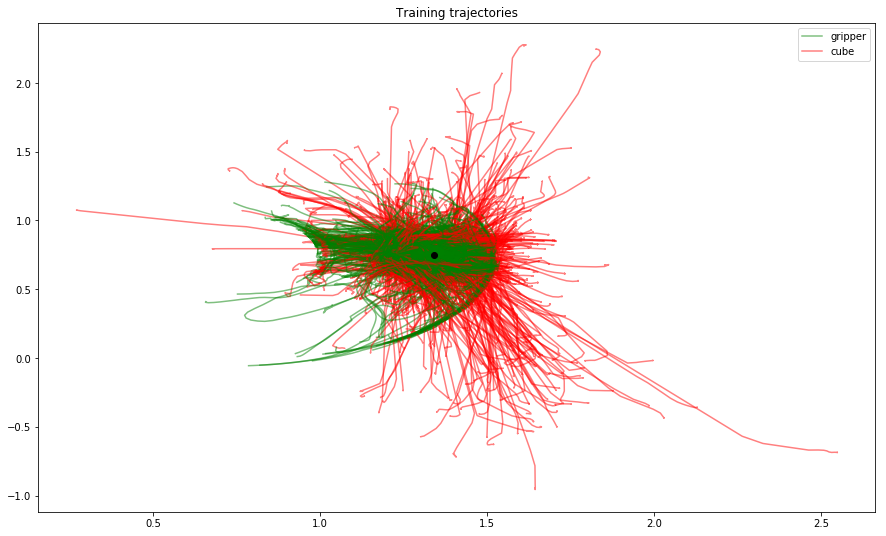

In [256]:
f = open("./data/transition_multi25_0noise_train.pk" , 'rb')
[true_traj,Acs] = pickle.load(f)
f.close()
true_traj = np.array(true_traj)
fig,axarr = plt.subplots(1,1,figsize=FIGSIZE)

plt.scatter(true_traj[0,0,0],true_traj[0,0,1], zorder=3, c='black')
plt.plot(true_traj[0,:,0],true_traj[0,:,1] , c="green",alpha=0.5, label="gripper")
plt.plot(true_traj[0,:,3],true_traj[0,:,4] , c="red",alpha=0.5, label="cube")
for j in range(1,len(true_traj)):
    plt.plot(true_traj[j,:,0],true_traj[j,:,1] , c="green",alpha=0.5)
    if np.max( np.linalg.norm(true_traj[j,1:,3:5]-true_traj[j,:-1,3:5], axis=1))>0:
        plt.plot(true_traj[j,:,3],true_traj[j,:,4] , c="red",alpha=0.5)
plt.legend()
plt.title("Training trajectories")

In [4]:
filename = "/home/tim/Documents/stage-m2/tf_test/data/random.pk"

with open(filename, 'rb') as fr:
    Episodes = pickle.load(fr)

In [9]:
Episodes['o'][0,:,0]

array([1.34180379, 1.33577621, 1.33846021, 1.3332926 , 1.33391452,
       1.31703699, 1.31118453, 1.30464613, 1.3057971 , 1.30386674,
       1.30770147, 1.30743253, 1.30398917, 1.30519044, 1.31167841,
       1.31235564, 1.30756509, 1.30773604, 1.32207823, 1.31073666,
       1.31248605, 1.31116688, 1.30917072, 1.31184423, 1.33396614,
       1.31365728, 1.28294206, 1.27484608, 1.27462125, 1.27272403,
       1.27139318, 1.28216743, 1.28409111, 1.2774806 , 1.28694761,
       1.30161798, 1.31313264, 1.32078218, 1.333866  , 1.33670974,
       1.33737516, 1.33377981, 1.34028327, 1.32703054, 1.33763933,
       1.3511672 , 1.35977018, 1.34487188, 1.34286404, 1.33915031,
       1.34553504])

Text(0.5, 1.0, 'Training trajectories')

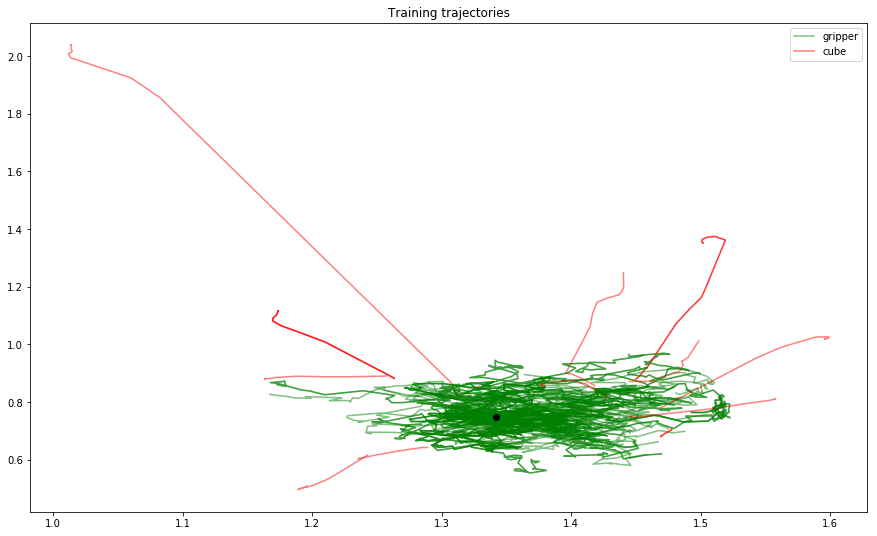

In [10]:
true_traj = Episodes['o']
fig,axarr = plt.subplots(1,1,figsize=FIGSIZE)

plt.scatter(true_traj[0,0,0],true_traj[0,0,1], zorder=3, c='black')
plt.plot(true_traj[0,:,0],true_traj[0,:,1] , c="green",alpha=0.5, label="gripper")
plt.plot(true_traj[0,:,3],true_traj[0,:,4] , c="red",alpha=0.5, label="cube")
for j in range(len(true_traj)):
    plt.plot(true_traj[j,:,0],true_traj[j,:,1] , c="green",alpha=0.5)
    if np.max( np.linalg.norm(true_traj[j,1:,3:5]-true_traj[j,:-1,3:5], axis=1))>0:
        plt.plot(true_traj[j,:,3],true_traj[j,:,4] , c="red",alpha=0.5)
plt.legend()
plt.title("Training trajectories")

In [16]:
type(Episodes) == dict

True

In [106]:
filename = "/home/tim/Documents/stage-m2/multi-task-her-rl/src/data/MultiTaskFetchArmNLP1-v0/11900/eval_episodes.pk"
with open(filename, 'rb') as fr:
    data = pickle.load(fr)

In [127]:
np.shape(data[0][0]['u'][1:])

(1, 50, 4)

In [142]:
a = np.array(np.random.randint(0,2,(2,51,4)))

In [149]:
np.sum(a[0] != a[1])

100

In [150]:
np.sum(a[0] == a[1])

104

In [162]:
confusion_matrice = [0,0,0,0]
env = a[0]
model = a[0]
for t in range(len(env)):
    for i in range(len(env[t])):
        g_e, g_m = env[t][i], model[t][i]
        if g_e == 1 and g_m == 1:
            confusion_matrice[0] += 1
        elif g_e == 0 and g_m == 1:
            confusion_matrice[1] += 1
        elif g_e == 0 and g_m == 0:
            confusion_matrice[2] += 1
        else:
            confusion_matrice[3] += 1
confusion_matrice

[112, 0, 92, 0]

In [170]:
[a,b,c,d] = np.zeros(4)

In [171]:
c

0.0

[]